# Multiple trials

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport algebra
%aimport util
%aimport inference
%aimport link
%aimport graph
%precision 4

'%.4f'

In [2]:
import os.path
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import linalg
from sklearn.decomposition.factor_analysis import FactorAnalysis
from scipy.io import loadmat, savemat
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat, lagmat2ds
import pandas as pd
from scipy.linalg import orth
from numpy.linalg import norm
from numpy import dstack, rollaxis

import simulation, util, inference, graph
from algebra import ichol_gauss, subspace

In [3]:
# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
sns.set_style("white")
PLDScolor = sns.xkcd_rgb["pale red"]
GPFAcolor =  sns.xkcd_rgb["medium green"]
GPVBcolor = sns.xkcd_rgb["denim blue"]

In [5]:
# dimensions
nsample = 10
ntrial = 10
ntime = 1000
nspike = 50
nlatent = 3

## Generate latent

### Lorenz attractor

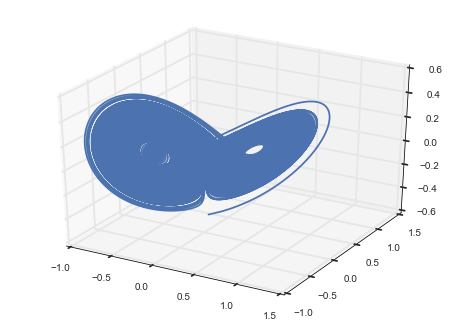

In [60]:
np.random.seed(0)
wait = 500
lorenz = simulation.lorenz(wait + nsample * ntrial * ntime, dt=3e-3, x0=np.random.random(3))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(lorenz[:, 0], lorenz[:, 1], lorenz[:, 2]);

In [61]:
x = lorenz[wait:, :].reshape((nsample, ntrial, ntime, -1))
for s in range(nsample):
    for m in range(ntrial):
        x[s, m, :] = (x[s, m, :] - x[s, m, :].mean(axis=0)) / norm(x[s, m, :], axis=0, ord=np.inf)

Simulate spike trains

In [8]:
np.random.seed(0)
low = np.log(20 / ntime)
aspk = (np.random.rand(nlatent, nspike) + 1) * np.sign(np.random.randn(nlatent, nspike))
bspk = np.vstack((low * np.ones(nspike), -10 * np.ones(nspike), -10 * np.ones(nspike), -3 * np.ones(nspike)))

In [10]:
for s in range(nsample):
    y, _, _ = simulation.spike(x[s, :], aspk, bspk)
    sample = {'y': y, 'x': x[s, :], 'a': aspk, 'b':bspk}
#     savemat('data/sample_lorenz{}'.format(s), sample)

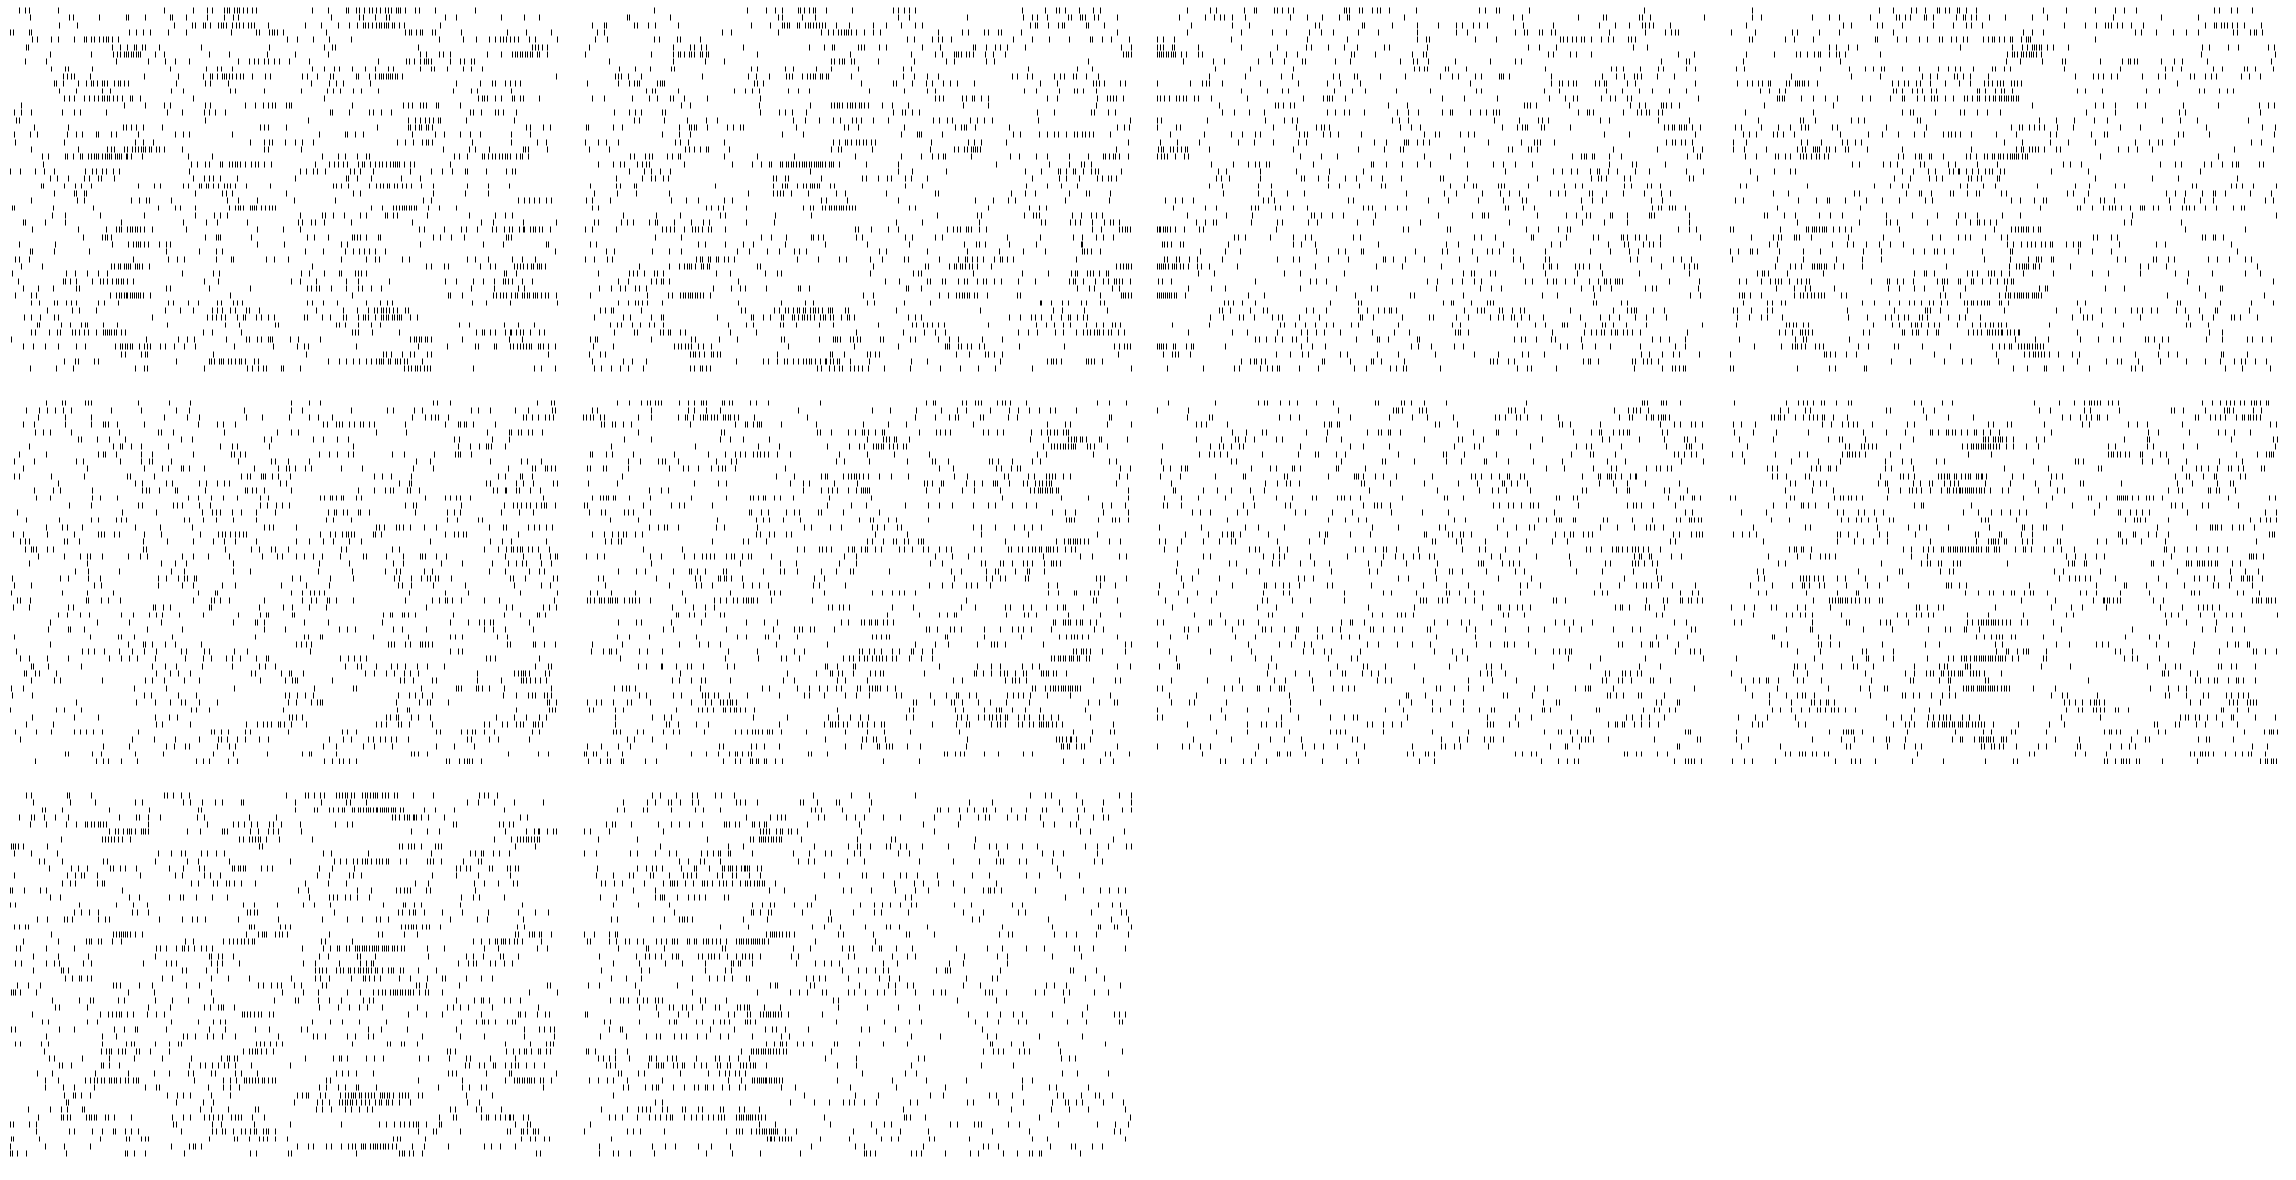

In [11]:
graph.rasterplot(y)

In [12]:
sigma = np.full(nlatent, fill_value=1.0)
omega = np.full(nlatent, fill_value=5e-4)

Load samples

In [13]:
fsample = ['data/sample_lorenz{}'.format(s) for s in range(nsample)]

In [223]:
GPVBAngle = pd.DataFrame(columns=['LatentAngle', 'LoadingAngle', 'Time', 'Model', 'Sample'])
for i, fname in enumerate(fsample):
    print('Sample {}'.format(i))
    sample = loadmat(fname)
    result = inference.multitrials(sample['y'], None, sigma, omega, x=sample['x'], ta=sample['a'], tb=sample['b'], lag=3, rank=100, tol=1e-5)]
    savemat(fname+'Proposed', result)
    df = pd.DataFrame(np.vstack((result['stat']['latentAngle'][1:] * 180 / np.pi, 
                      result['stat']['loadingAngle'][1:] * 180 / np.pi, 
                      np.cumsum(result['stat']['elapsed'][1:,2]))).T, columns=['LatentAngle', 'LoadingAngle', 'Time'])
    df['Model'] = 'GPVB'
    df['Sample'] = i
    GPVBAngle = GPVBAngle.append(df)

Sample 0

Inference starting
Iteration[1], posterior elapsed: 0.67, parameter elapsed: 0.68, total elapsed: 1.63, ELBO: -221597.4625
Iteration[2], posterior elapsed: 0.68, parameter elapsed: 0.66, total elapsed: 1.62, ELBO: -115922.6030
Iteration[3], posterior elapsed: 0.68, parameter elapsed: 0.67, total elapsed: 1.62, ELBO: -83473.1749
Iteration[4], posterior elapsed: 0.68, parameter elapsed: 0.68, total elapsed: 1.66, ELBO: -75577.1573
Iteration[5], posterior elapsed: 0.71, parameter elapsed: 0.75, total elapsed: 1.78, ELBO: -73855.8779
Iteration[6], posterior elapsed: 0.72, parameter elapsed: 0.66, total elapsed: 1.65, ELBO: -72856.8711
Iteration[7], posterior elapsed: 0.68, parameter elapsed: 0.65, total elapsed: 1.61, ELBO: -71939.6806
Iteration[8], posterior elapsed: 0.71, parameter elapsed: 0.73, total elapsed: 1.73, ELBO: -71555.5072
Iteration[9], posterior elapsed: 0.70, parameter elapsed: 0.68, total elapsed: 1.66, ELBO: -71102.1099
Iteration[10], posterior elapsed: 0.68, pa

In [262]:
GPFAresult = ['data/sample_lorenz{}GPFA'.format(s) for s in range(nsample)]
GPFAAngle = pd.DataFrame(columns=['LatentAngle', 'LoadingAngle', 'Time', 'Model', 'Sample'])
for i, fname in enumerate(GPFAresult):
    GPFA = loadmat(fname)
    df = pd.DataFrame(np.hstack((GPFA['latentAngles'] * 180 / np.pi, 
                      GPFA['loadingAngles'] * 180 / np.pi, 
                      np.cumsum(GPFA['iterTime'])[...,None])), columns=['LatentAngle', 'LoadingAngle', 'Time'])
    df['Model'] = 'GPFA'
    df['Sample'] = i
    GPFAAngle = GPFAAngle.append(df)

In [263]:
PLDSresult = ['data/sample_lorenz{}PLDS'.format(s) for s in range(nsample)]
PLDSAngle = pd.DataFrame(columns=['LatentAngle', 'LoadingAngle', 'Time', 'Model', 'Sample'])
for i, fname in enumerate(PLDSresult):
    PLDS = loadmat(fname)
    df = pd.DataFrame(np.hstack((PLDS['latentAngles'] * 180 / np.pi, 
                      PLDS['loadingAngles'] * 180 / np.pi, 
                      np.cumsum(PLDS['StepTimes'])[...,None])), columns=['LatentAngle', 'LoadingAngle', 'Time'])
    df['Model'] = 'PLDS'
    df['Sample'] = i
    PLDSAngle = PLDSAngle.append(df)

In [435]:
GPVBlast = GPVBAngle.groupby('Sample').last()
bestGPVB = GPVBlast.ix[proplast['LatentAngle'].idxmin()]
ibestGPVB = int(bestGPVB.name)

/Users/yuan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


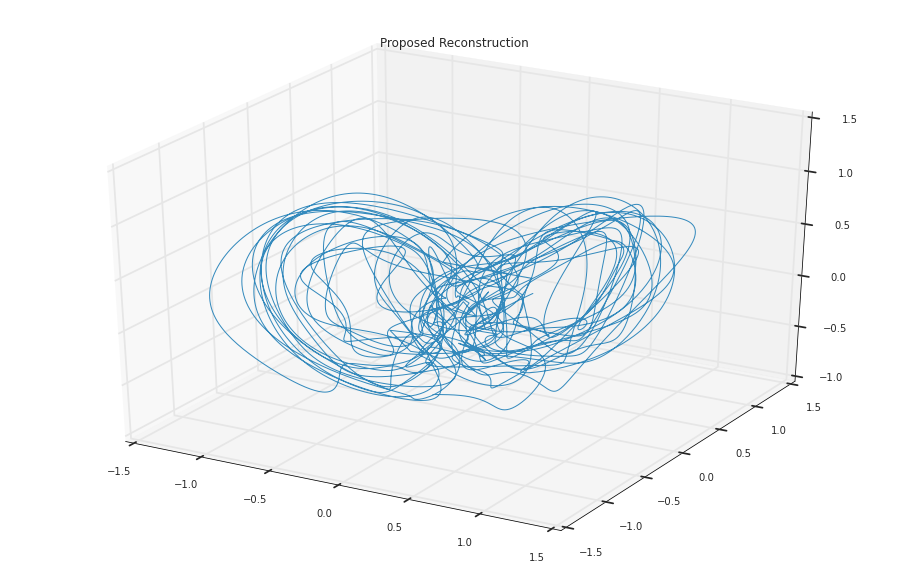

In [464]:
result = loadmat('data/sample_lorenz{}Proposed'.format(ibestGPVB))
rotated = np.empty_like(result['posterior']['mu'][0,0])
for m in range(ntrial):
    rotated[m, :] = util.rotate(result['posterior']['mu'][0,0][m, :], x[ibestGPVB, m, :])
fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')
# recon = result['posterior']['mu'][0,0].reshape(-1, nlatent)
recon = rotated.reshape(-1, nlatent)
ax.plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
title('Proposed Reconstruction');
plt.savefig('figure/Proposed.pdf')

LatentAngle      46.7345
LoadingAngle    63.89423
Time            12.75671
Model               GPFA
Name: 8.0, dtype: object


/Users/yuan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


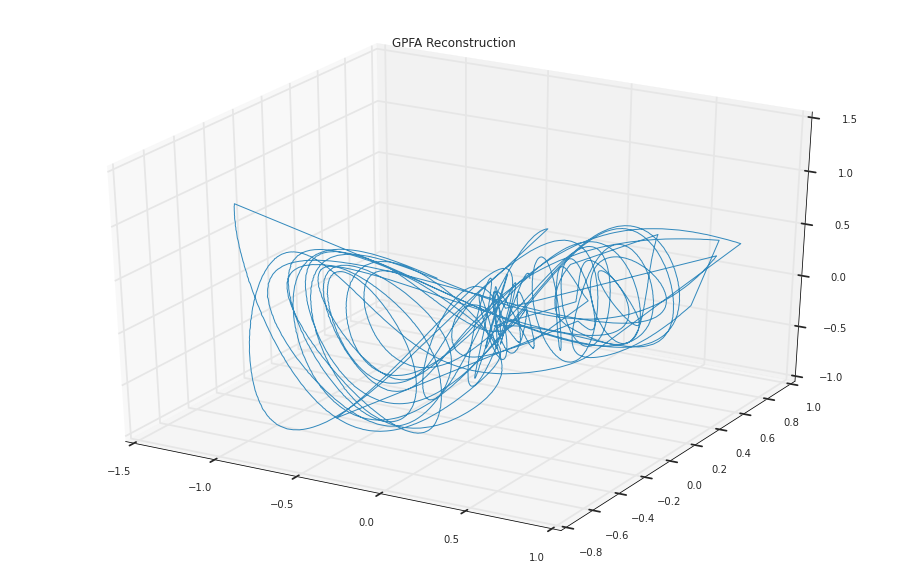

In [463]:
GPFAlast = GPFAAngle.groupby('Sample').last()
bestGPFA = GPFAlast.ix[GPFAlast['LatentAngle'].idxmin()]
print(bestGPFA)
ibestGPFA = int(bestGPFA.name)
bestGPFAresult = loadmat('data/sample_lorenz{}GPFA'.format(ibestGPFA))
bestGPFAx = np.squeeze(bestGPFAresult['seqTrain']['xsm'])

rotated = np.empty_like(x[ibestGPFA])
for m in range(ntrial):
    rotated[m, :] = util.rotate(bestGPFAx[m].T, x[ibestGPFA, m, :])
fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')
# recon = result['posterior']['mu'][0,0].reshape(-1, nlatent)
recon = rotated.reshape(-1, nlatent)
ax.plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
title('GPFA Reconstruction');
plt.savefig('figure/GPFA.pdf')

LatentAngle     37.82178
LoadingAngle    18.69694
Time              604.91
Model               PLDS
Name: 9.0, dtype: object


/Users/yuan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


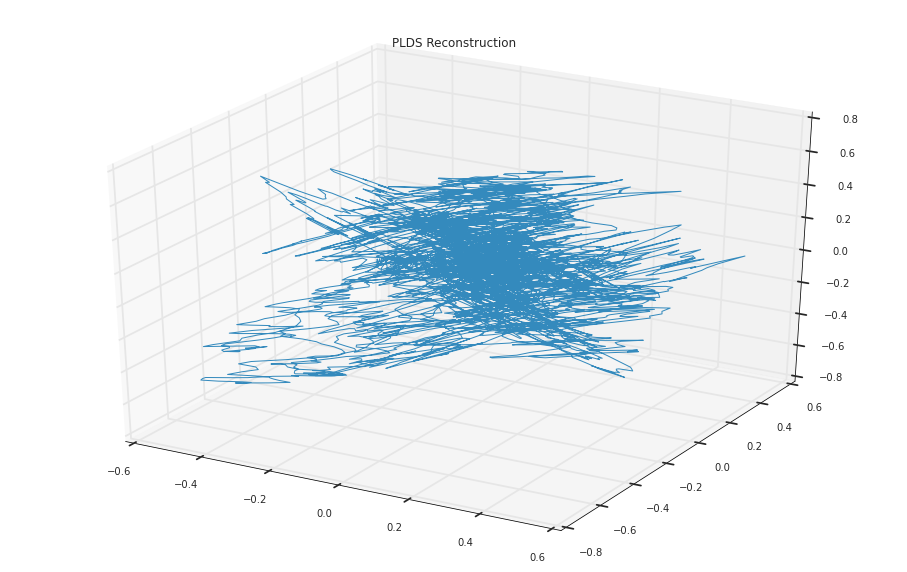

In [462]:
PLDSlast = PLDSAngle.groupby('Sample').last()
bestPLDS = PLDSlast.ix[PLDSlast['LatentAngle'].idxmin()]
print(bestPLDS)

ibestPLDS = int(bestPLDS.name)
bestPLDSresult = loadmat('data/sample_lorenz{}PLDS'.format(ibestPLDS))
bestPLDSx = np.squeeze(bestPLDSresult['xsm']).T.reshape(ntrial, -1, nlatent)

rotated = np.empty_like(x[ibestGPFA])
for m in range(ntrial):
    rotated[m, :] = util.rotate(bestPLDSx[m, :], x[ibestGPFA, m, :])
fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')
# recon = result['posterior']['mu'][0,0].reshape(-1, nlatent)
recon = rotated.reshape(-1, nlatent)
ax.plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
title('PLDS Reconstruction');
plt.savefig('figure/PLDS.pdf')

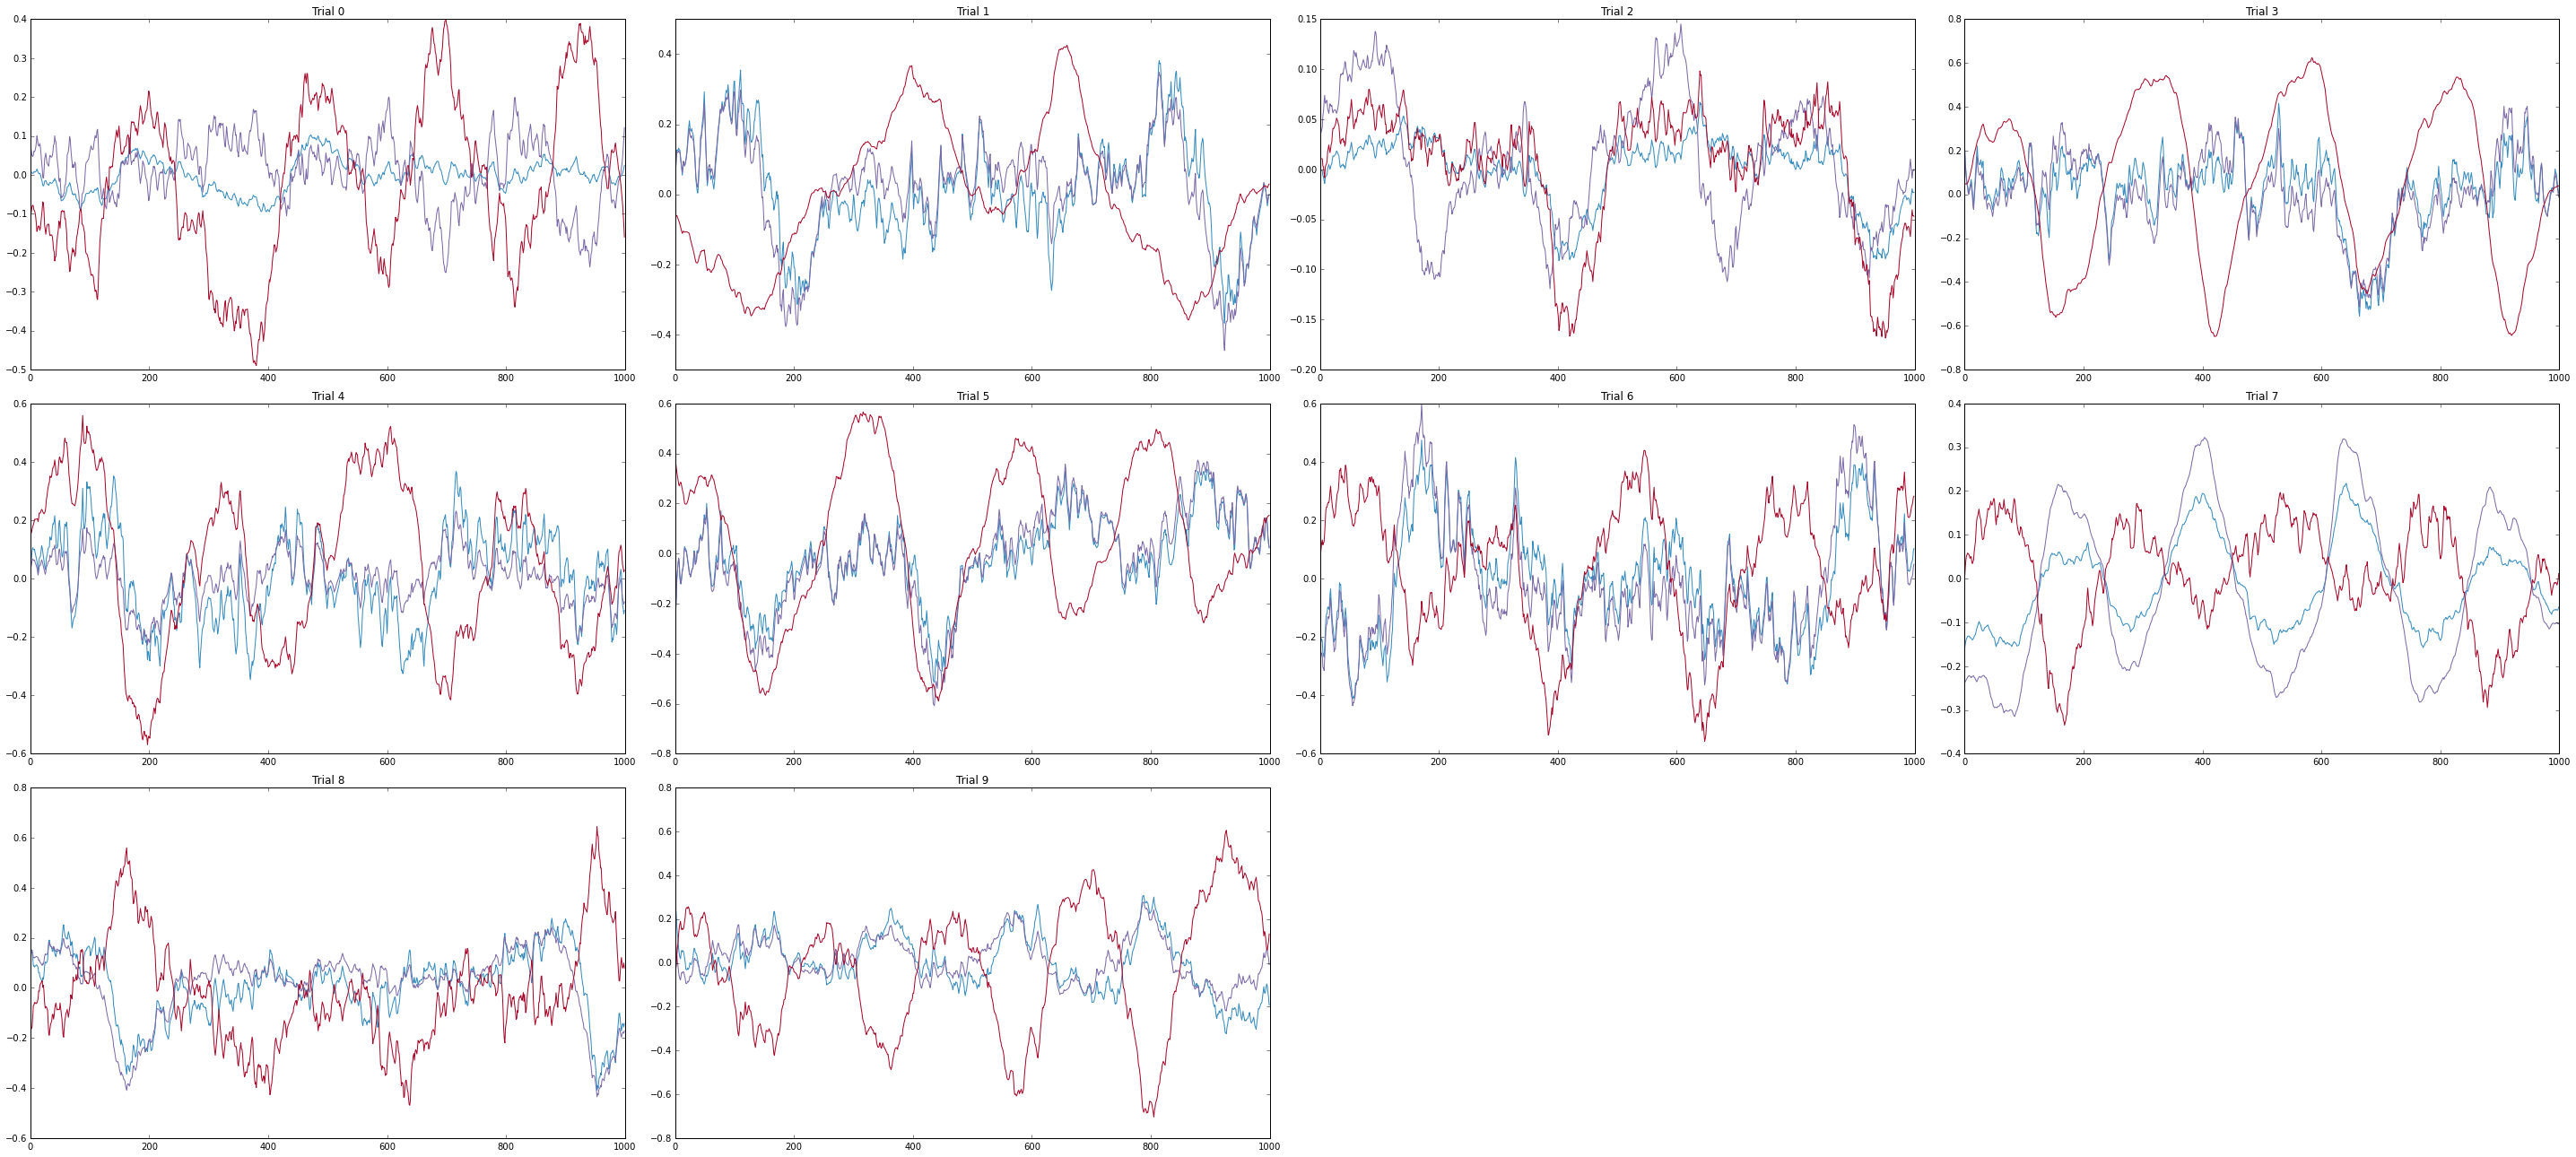

In [340]:
graph.dynplot(rotated)

/Users/yuan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


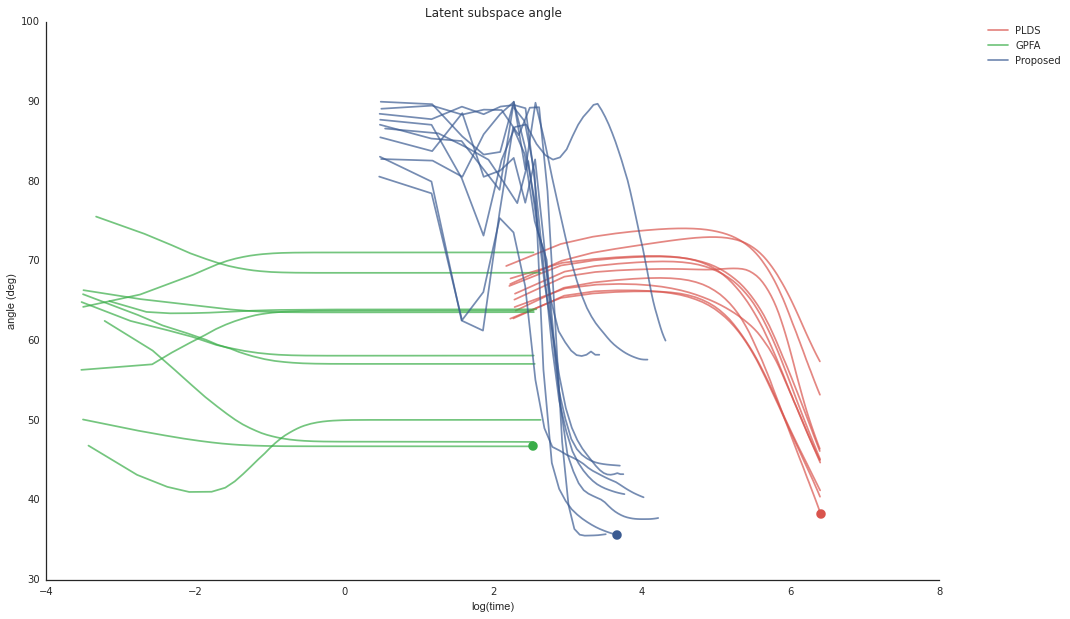

In [461]:
# Latent subspace angle plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
for key, grp in PLDSAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LatentAngle'], color=PLDScolor, alpha=0.7);
for key, grp in GPFAAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LatentAngle'], color=GPFAcolor, alpha=0.7);
for key, grp in ProposedAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LatentAngle'], color=GPVBcolor, alpha=0.7);

PLDSgrp = PLDSAngle.groupby('Sample')
angle = PLDSgrp.get_group(ibestPLDS).dropna().tail(1)['LatentAngle']
time = PLDSgrp.get_group(ibestPLDS).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=PLDScolor, lw=5)
    
GPFAgrp = GPFAAngle.groupby('Sample')
angle = GPFAgrp.get_group(ibestGPFA).dropna().tail(1)['LatentAngle']
time = GPFAgrp.get_group(ibestGPFA).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=GPFAcolor, lw=5)

GPVBgrp = GPVBAngle.groupby('Sample')
angle = GPVBgrp.get_group(ibestGPVB).dropna().tail(1)['LatentAngle']
time = GPVBgrp.get_group(ibestGPVB).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=GPVBcolor, lw=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlim([-4, 8])
plt.xlabel('log(time)');
plt.ylabel('angle (deg)');
PLDSline = mlines.Line2D([], [], color=PLDScolor, alpha=0.7, label='PLDS');
GPFAline = mlines.Line2D([], [], color=GPFAcolor, alpha=0.7, label='GPFA');
GPVBline = mlines.Line2D([], [], color=GPVBcolor, alpha=0.7, label='Proposed');
plt.legend(handles=[PLDSline, GPFAline, GPVBline], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('Latent subspace angle');
plt.savefig('figure/latent.pdf')

/Users/yuan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


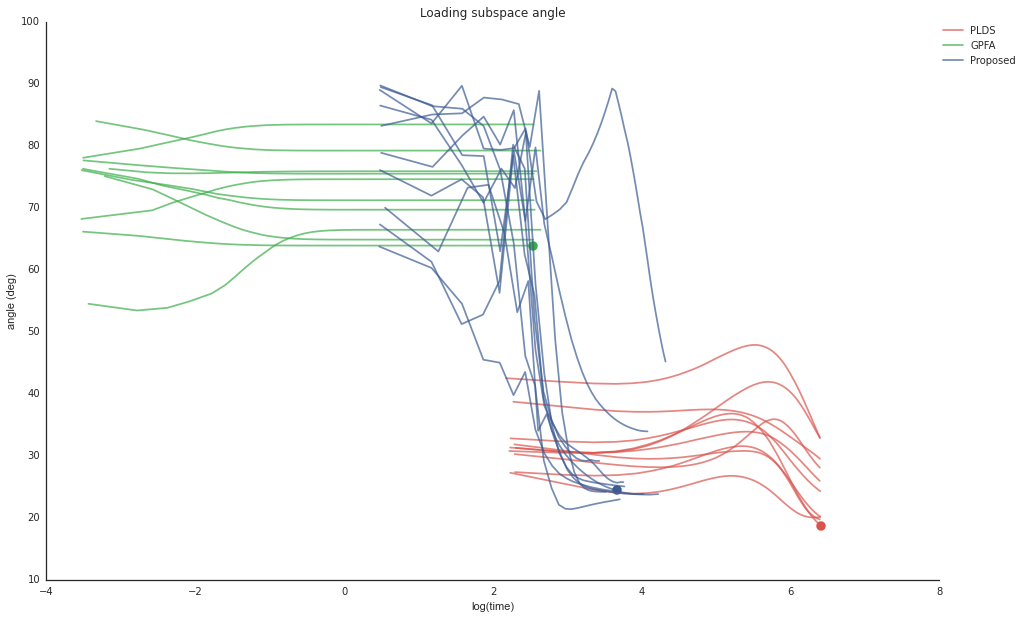

In [460]:
# Loading subspace angle plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
for key, grp in PLDSAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LoadingAngle'], color=PLDScolor, alpha=0.7);
for key, grp in GPFAAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LoadingAngle'], color=GPFAcolor, alpha=0.7);
for key, grp in ProposedAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LoadingAngle'], color=GPVBcolor, alpha=0.7);

PLDSgrp = PLDSAngle.groupby('Sample')
angle = PLDSgrp.get_group(ibestPLDS).dropna().tail(1)['LoadingAngle']
time = PLDSgrp.get_group(ibestPLDS).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=PLDScolor, lw=5)
    
GPFAgrp = GPFAAngle.groupby('Sample')
angle = GPFAgrp.get_group(ibestGPFA).dropna().tail(1)['LoadingAngle']
time = GPFAgrp.get_group(ibestGPFA).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=GPFAcolor, lw=5)

GPVBgrp = GPVBAngle.groupby('Sample')
angle = GPVBgrp.get_group(ibestGPVB).dropna().tail(1)['LoadingAngle']
time = GPVBgrp.get_group(ibestGPVB).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=GPVBcolor, lw=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlim([-4, 8])
plt.xlabel('log(time)');
plt.ylabel('angle (deg)');
PLDSline = mlines.Line2D([], [], color=PLDScolor, alpha=0.7, label='PLDS');
GPFAline = mlines.Line2D([], [], color=GPFAcolor, alpha=0.7, label='GPFA');
GPVBline = mlines.Line2D([], [], color=GPVBcolor, alpha=0.7, label='Proposed');
plt.legend(handles=[PLDSline, GPFAline, GPVBline], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.);
plt.title('Loading subspace angle');
plt.savefig('figure/loading.pdf')

In [43]:
sample = loadmat('data/sample_lorenz9')
yhat = np.empty_like(sample['y'])
for i in range(sample['y'].shape[0]):
    model = inference.gpvb(sample['y'], None, sigma, omega, rank=100, x=sample['x'], lag=3, truea=sample['a'], trueb=sample['b'], testidx=[i], tol=1e-5)
    yhat[i, :, :] = model['test']['yhat']


Inference starting
Iteration[1], posterior elapsed: 0.62, parameter elapsed: 0.64, total elapsed: 1.52, ELBO: -201114.0217
Iteration[2], posterior elapsed: 0.62, parameter elapsed: 0.76, total elapsed: 1.65, ELBO: -106680.5018
Iteration[3], posterior elapsed: 0.62, parameter elapsed: 0.64, total elapsed: 1.52, ELBO: -77945.1876
Iteration[4], posterior elapsed: 0.61, parameter elapsed: 0.63, total elapsed: 1.50, ELBO: -70886.3323
Iteration[5], posterior elapsed: 0.79, parameter elapsed: 0.65, total elapsed: 1.71, ELBO: -68941.7030
Iteration[6], posterior elapsed: 0.63, parameter elapsed: 0.65, total elapsed: 1.54, ELBO: -67486.4704
Iteration[7], posterior elapsed: 0.64, parameter elapsed: 0.84, total elapsed: 1.75, ELBO: -66521.5965
Iteration[8], posterior elapsed: 0.66, parameter elapsed: 0.73, total elapsed: 1.66, ELBO: -65943.2448
Iteration[9], posterior elapsed: 0.63, parameter elapsed: 0.72, total elapsed: 1.61, ELBO: -65586.1410
Iteration[10], posterior elapsed: 0.79, parameter e

In [48]:
prediction = {'y':sample['y'], 'yhat': yhat}
savemat('data/sample_lorenz9GPVBpred', prediction)

In [51]:
stats.poisson.logpmf(sample['y'].ravel(), yhat.ravel()).mean()

-0.1187

In [52]:
x.shape

(10, 10, 1000, 3)

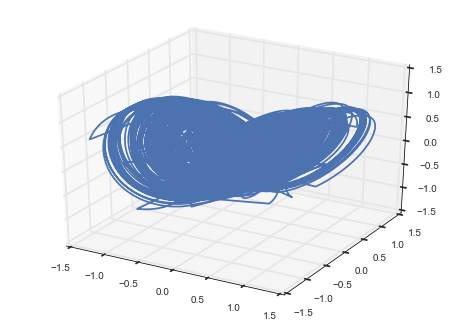

In [59]:
fig = plt.figure()
ax = fig.gca(projection='3d')
dyn = x.reshape((-1, 3))
ax.plot(dyn[:, 0], dyn[:, 1], dyn[:, 2]);

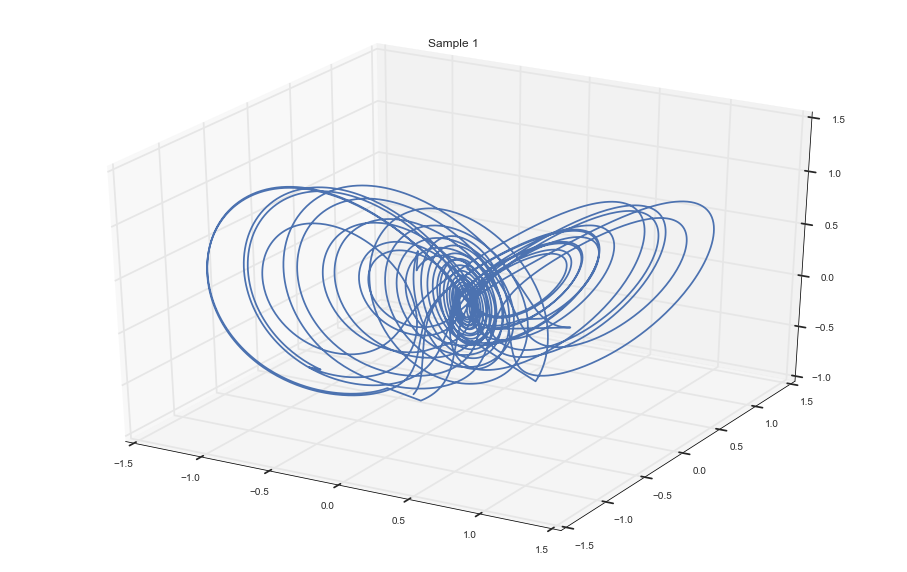

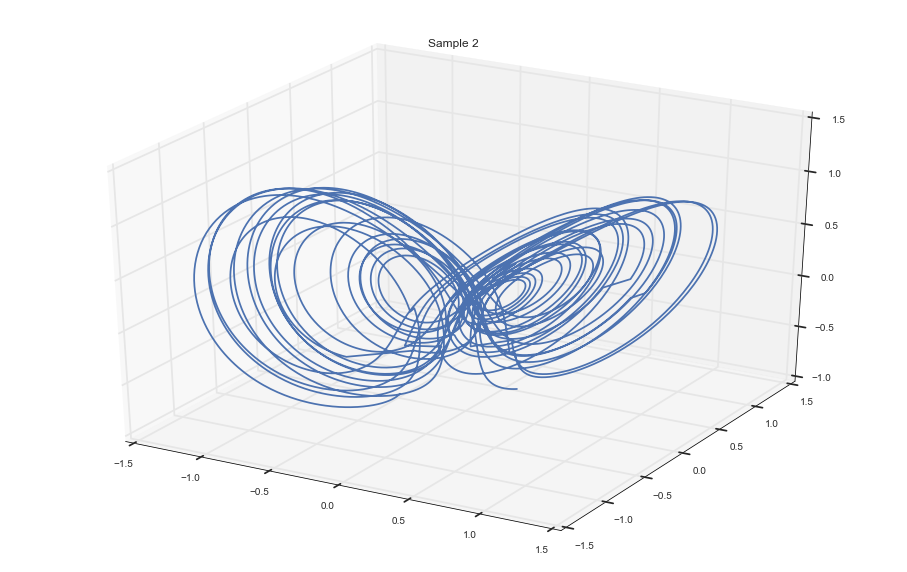

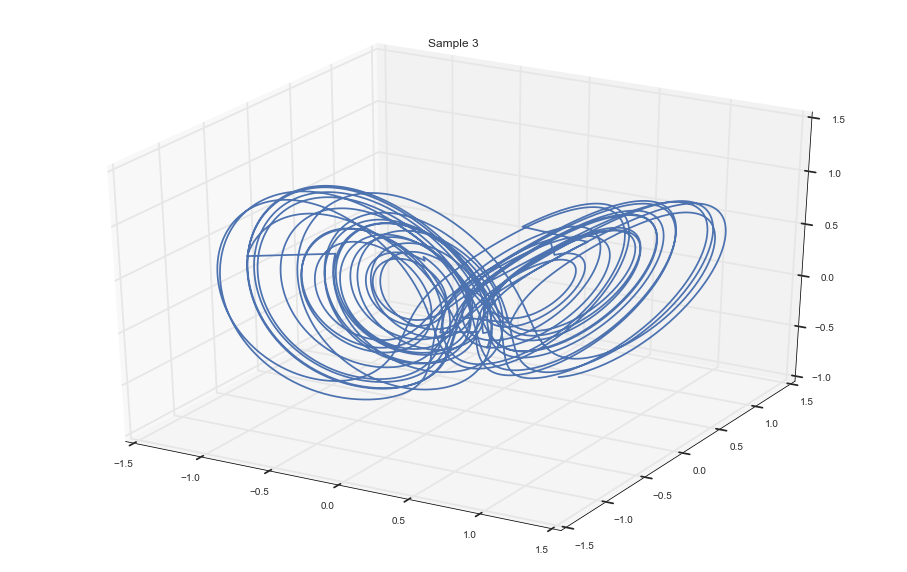

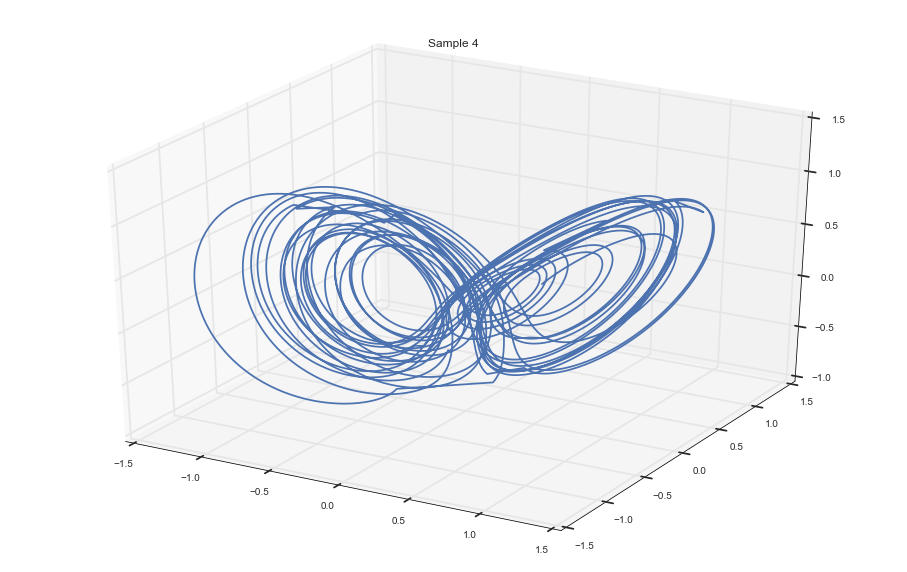

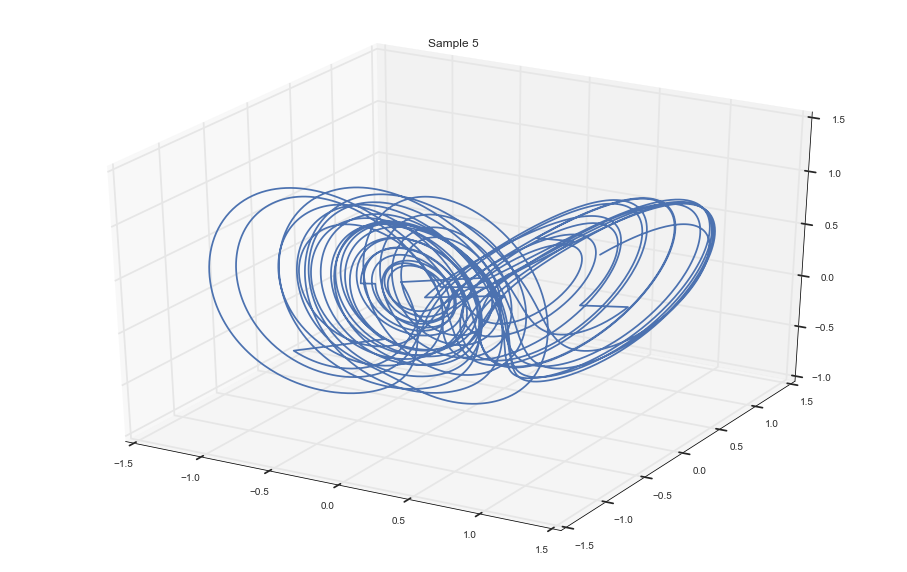

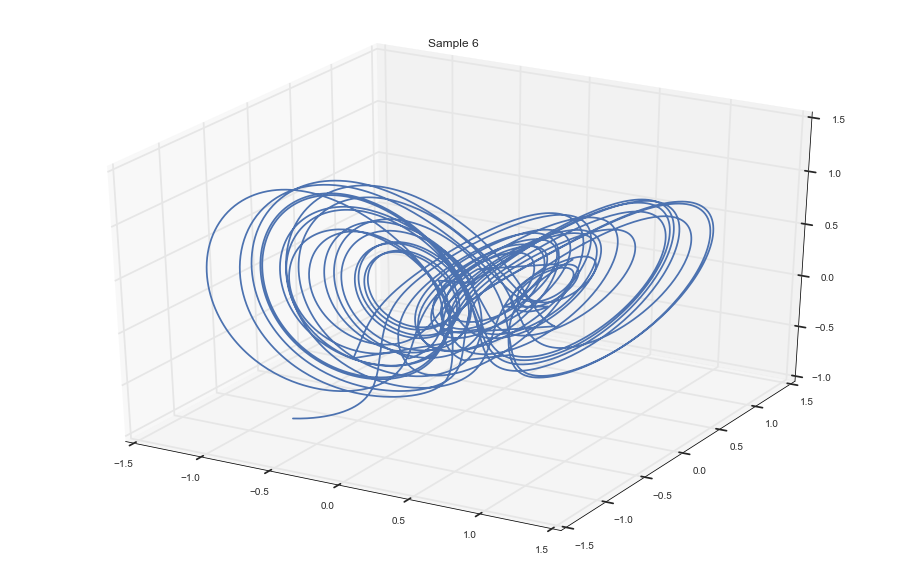

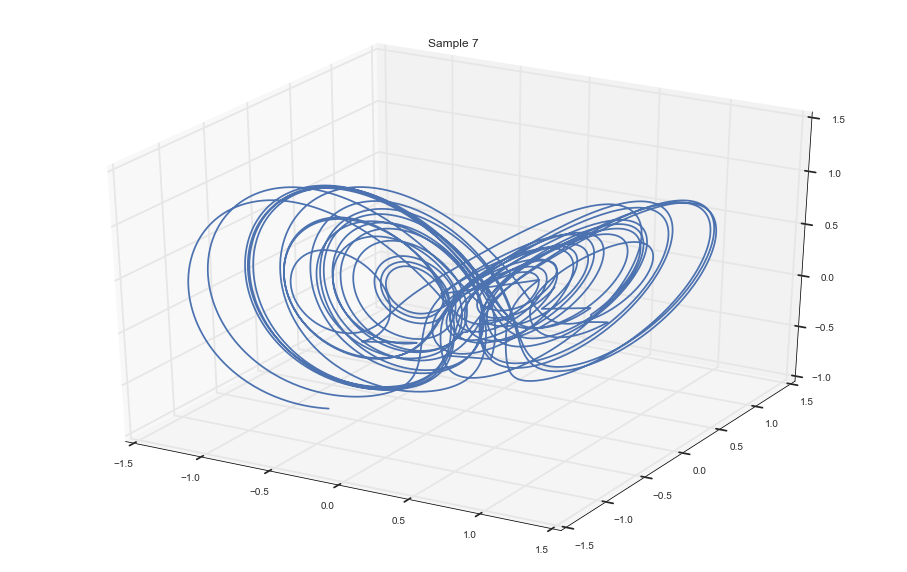

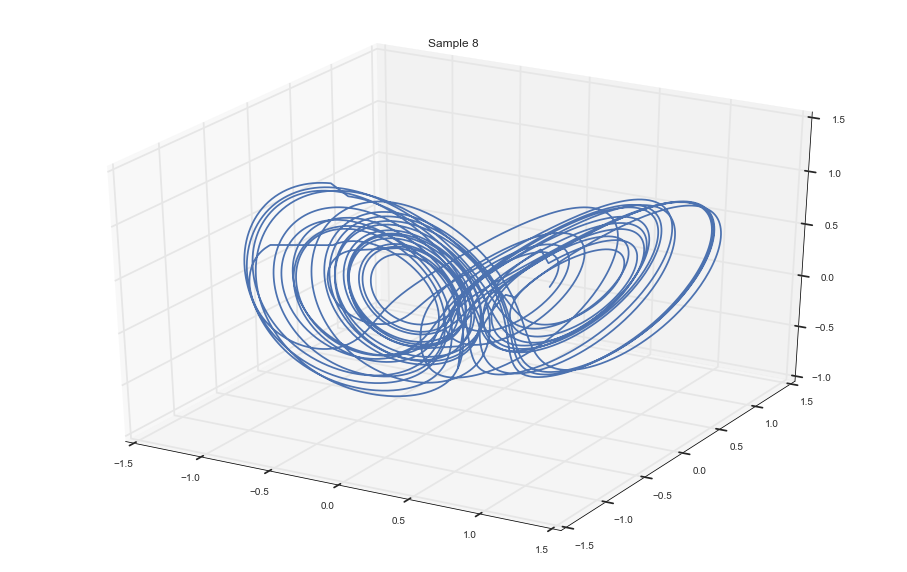

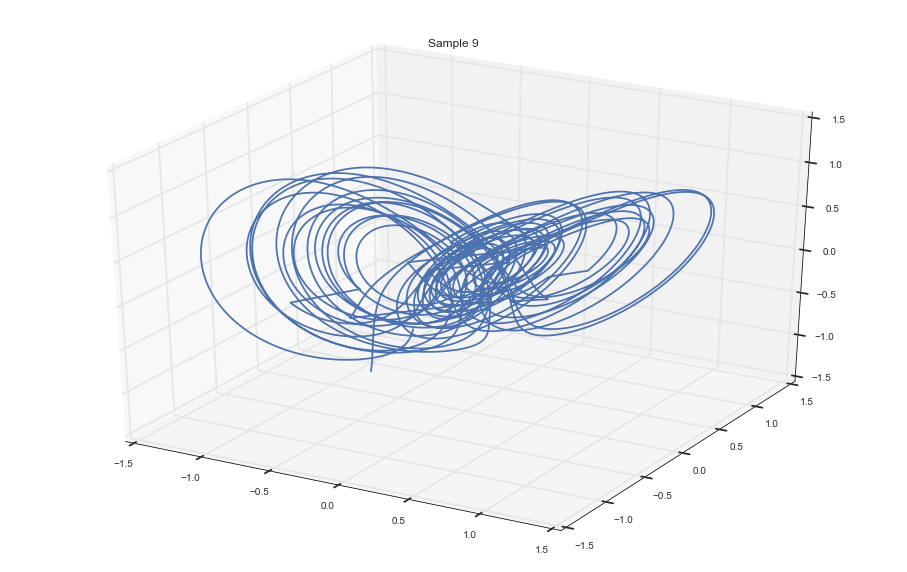

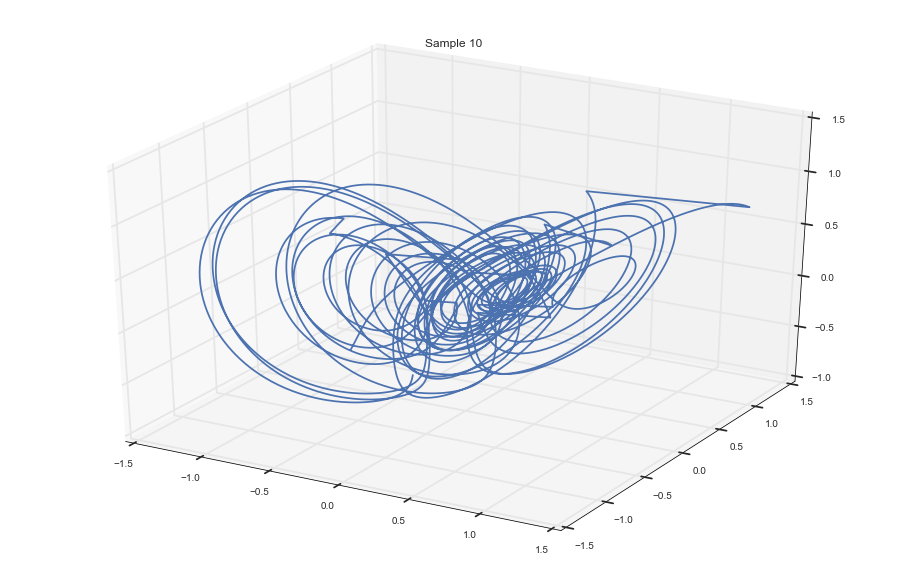

In [62]:
for i in range(10):
    fig = plt.figure(figsize=(16, 10))
    ax = fig.gca(projection='3d')
    dyn = x[i, :].reshape((-1, 3))
    ax.plot(dyn[:, 0], dyn[:, 1], dyn[:, 2]);
    plt.title('Sample {}'.format(i+1));
#     plt.savefig('figure/sample{}_true_latent.pdf'.format(i+1));